In [1]:
%matplotlib inline
from __future__ import division

## Prepare the data from Kaggle

In [21]:
%cd data/kaggle

/home/ubuntu/courses/deeplearning1/nbs/data/kaggle


In [28]:
!rm -rf test
!rm -rf train
!rm -rf validation

In [29]:
!unzip -q test.zip
!unzip -q train.zip

In [30]:
# Split the training data from Kaggle into train/validation

import glob
import numpy as np
import shutil
import os

all_train_images = glob.glob("train/*.jpg")
num_val_samples = int(len(all_train_images) * 0.1)
val_images = np.random.choice(all_train_images, num_val_samples, replace=False)

if not os.path.exists("validation"):
    os.makedirs("validation")

for img_path in val_images:
    shutil.move(img_path, "validation/")

2500


In [31]:
# Move into category sub-directories to fit the structure expected by vgg.get_batches()
!mkdir train/dogs
!mkdir train/cats

!mv train/dog.*.jpg train/dogs/
!mv train/cat.*.jpg train/cats/

!mkdir validation/dogs
!mkdir validation/cats

!mv validation/dog.*.jpg validation/dogs/
!mv validation/cat.*.jpg validation/cats/

In [32]:
%cd ../..

/home/ubuntu/courses/deeplearning1/nbs


## Define VGG16 model

In [2]:
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
vgg = Vgg16()

### Fine tune - add layer for dog/cat classification

In [5]:
batch_size = 64
train_batches = vgg.get_batches("data/kaggle/train", batch_size=batch_size)
val_batches = vgg.get_batches("data/kaggle/validation", batch_size=batch_size)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


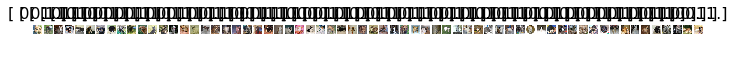

In [6]:
# Check the data
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [7]:
vgg.finetune(train_batches)

## Overfit - minimize dropout
At this point, our train loss/accuracy is better than validation loss/accuracy -> we are underfitting. This is because of too strong dropout in the VGG16 model.

Plan:
    - separate conv and fc model
    - save conv features (to make training more efficient)
    - retrain fc model with .0 dropout (or just low)


In [17]:
# vgg.model.summary()
vgg.model.load_weights("vgg16_dogscats_epoch_3.h5")

In [36]:
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential


def split_vgg_model(model):
    """ Take Keras model and return two models (tuple): conv layers at the beginning, dense layers. """
    last_conv_idx = [index for index,layer in enumerate(model.layers) if type(layer) is Convolution2D][-1]
    conv_model = Sequential(model.layers[:last_conv_idx+1])
    fc_model = Sequential(model.layers[last_conv_idx+1:])
    #conv_model.summary()
    return conv_model, fc_model
    
conv_model, fc_model = split_vgg_model(vgg.model)

In [37]:
batch_x, batch_y = next(train_batches)
prediction = conv_model.predict(batch_x)
print prediction[0].shape

(512, 14, 14)


In [34]:
def make_fc_model(vgg_fc_model):
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

(512, 16, 16)


## Train

In [9]:
for i in range(5):
    print 'epoch', i
    vgg.fit(train_batches, val_batches, nb_epoch=1)
    vgg.model.optimizer.lr.set_value(np.float32(vgg.model.optimizer.lr.get_value() / 1.5))
    vgg.model.save_weights('vgg16_dogscats_epoch_%d.h5' % i)

epoch 0
Epoch 1/1
22500/22500 [==============================] - 618s - loss: 0.1184 - acc: 0.9695 - val_loss: 0.0621 - val_acc: 0.9824
epoch 1
Epoch 1/1
22500/22500 [==============================] - 619s - loss: 0.0859 - acc: 0.9788 - val_loss: 0.0640 - val_acc: 0.9820
epoch 2
Epoch 1/1
22500/22500 [==============================] - 619s - loss: 0.0817 - acc: 0.9800 - val_loss: 0.0584 - val_acc: 0.9848
epoch 3
Epoch 1/1
22500/22500 [==============================] - 619s - loss: 0.0681 - acc: 0.9822 - val_loss: 0.0449 - val_acc: 0.9852
epoch 4
Epoch 1/1
22500/22500 [==============================] - 619s - loss: 0.0643 - acc: 0.9825 - val_loss: 0.0479 - val_acc: 0.9832


In [ ]:
vgg.model.load_weights("vgg16_dogscats_epoch_3.h5")

## Analyze model's predictions

In [26]:
batch_size = 64
valid_path = "data/kaggle/validation"

In [10]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2500 images belonging to 2 classes.


In [11]:
expected_labels = val_batches.classes

In [16]:
predicted_scores = probs[:,0] # prob of cat (>0.5 is cat)
predicted_labels = np.round(1-predicted_scores) # 0 cat, 1 dog
print predicted_labels
print expected_labels

[ 0.  0.  0. ...,  1.  1.  1.]
[0 0 0 ..., 1 1 1]


In [31]:
from keras.preprocessing import image
filenames = val_batches.filenames

def plots_idx(idx, titles=None):
    """ Plot image by index in the validation set. """
    titles = predicted_scores[idx]
    plots([image.load_img(valid_path + "/" + filenames[i]) for i in idx], titles=titles)

In [64]:
# Random wrong predictions
wrong_idx = np.where(predicted_labels != expected_labels)[0]
correct_idx = np.where(predicted_labels == expected_labels)[0]
print 'wrong', len(wrong_idx)
print 'correct', len(correct_idx)

wrong_cats_idx = np.where((expected_labels == 0) & (expected_labels != predicted_labels))[0]
wrong_dogs_idx = np.where((expected_labels == 1) & (expected_labels != predicted_labels))[0]
print 'wrong cats', len(wrong_cats_idx)
print 'wrong dogs', len(wrong_dogs_idx)

wrong 42
correct 2458
wrong cats 23
wrong dogs 19


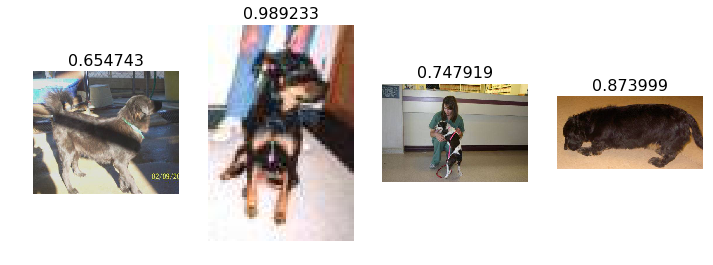

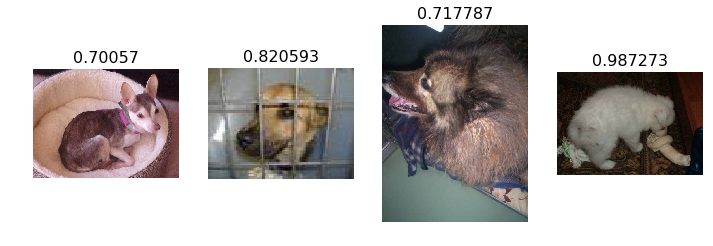

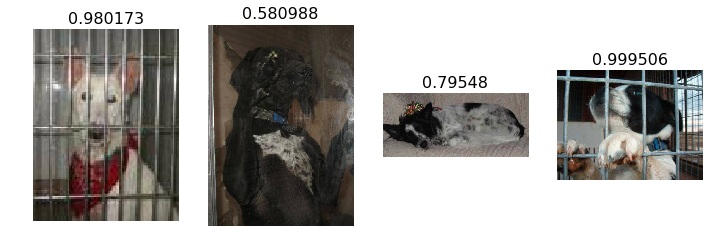

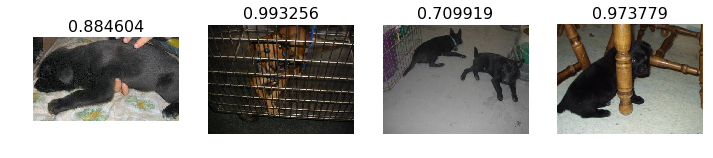

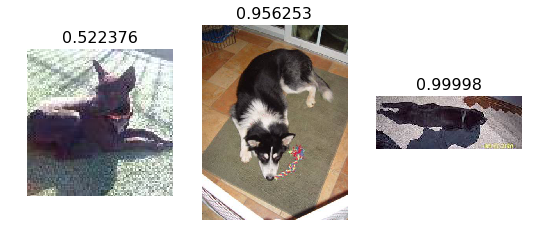

In [68]:
for i in range(0, len(wrong_dogs_idx), 4):
    plots_idx(wrong_dogs_idx[i:i+4])

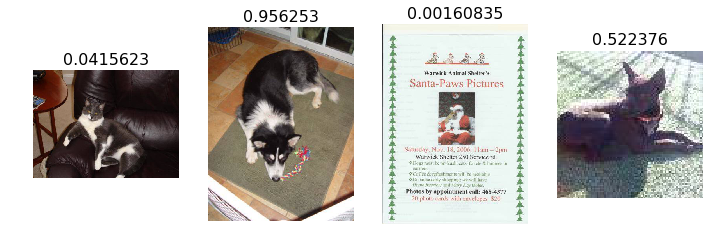

In [35]:
plots_idx(np.random.choice(wrong_idx, 4, replace=False))

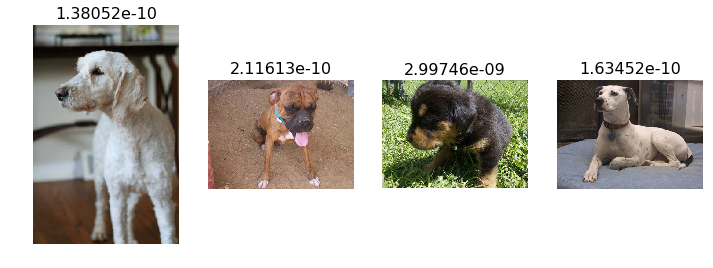

In [38]:
# Most confident correct preds
plots_idx(np.argsort(predicted_scores[correct_idx])[:4])

In [ ]:
# Most confident correct dogs


[1407 1426 1467 1489 1514 1571 1703 1737 1781 1819 1910 2068 2114 2153 2168 2194 2353 2465 2474]
[ 0.6547  0.9892  0.7479  0.874   0.7006  0.8206  0.7178  0.9873  0.9802  0.581   0.7955  0.9995
  0.8846  0.9933  0.7099  0.9738  0.5224  0.9563  1.    ]
[18 11 13  1  7  8 15 17 12  3  5 10  2  6 14  4  0  9 16]


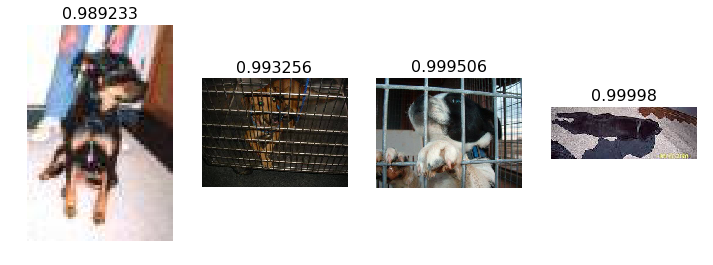

In [76]:
# Most confidently predicted but wrong
plots_idx(wrong_dogs_idx[np.argsort(predicted_scores[wrong_dogs_idx])[-4:]])

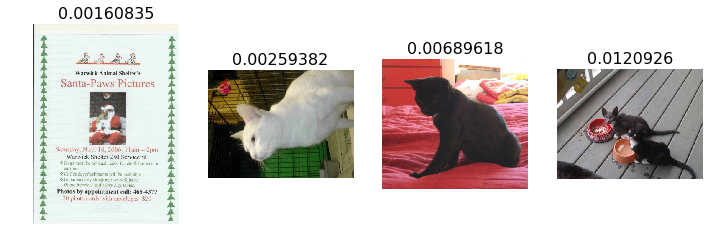

In [77]:
plots_idx(wrong_cats_idx[np.argsort(predicted_scores[wrong_cats_idx])[:4]])

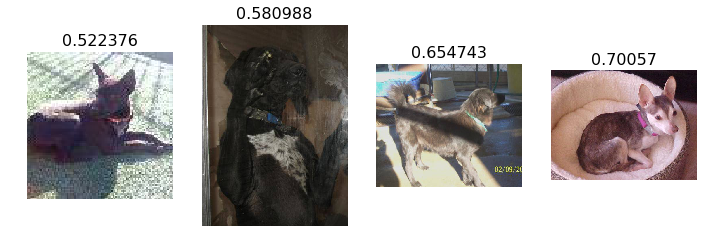

In [78]:
# Least confident, wrong
plots_idx(wrong_dogs_idx[np.argsort(predicted_scores[wrong_dogs_idx])[:4]])

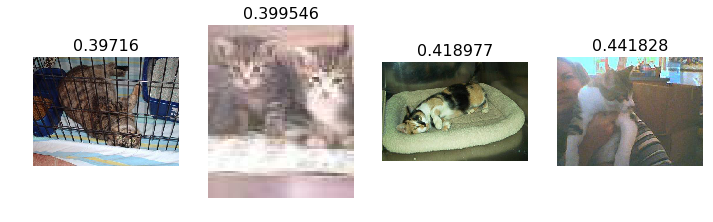

In [79]:
plots_idx(wrong_cats_idx[np.argsort(predicted_scores[wrong_cats_idx])[-4:]])

## Predict Kaggle competitions test data

In [11]:
import glob
import re
import math

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

def id_from_img_filepath(filepath):
    return re.search(r"(\d+)\.jpg", filepath).group(1)

def load_test_samples(filepaths):
    gen = ImageDataGenerator()
    x_buffer = []
    id_buffer = []
    for filepath in filepaths:
        img = img_to_array(load_img(filepath, target_size=(224,224)))
        x = gen.standardize(gen.random_transform(img))
        sample_id = id_from_img_filepath(filepath)
        x_buffer.append(x)
        id_buffer.append(sample_id)
        
    return np.array(x_buffer), id_buffer

def load_test_batches(directory, batch_size=64):
    filepaths = glob.glob(directory + "/*.jpg")
    num_batches = int(math.ceil(len(filepaths) / batch_size))
    for batch_i in range(num_batches):
        yield load_test_samples(filepaths[batch_i*batch_size:batch_i*batch_size+batch_size])

In [21]:
test_batch = next(load_test_batches("data/kaggle/test"))
print test_batch

(array([[[[ 109.,  108.,  106., ...,  242.,  242.,  240.],
         [ 107.,  106.,  105., ...,  245.,  244.,  243.],
         [ 103.,  103.,  103., ...,  244.,  244.,  244.],
         ..., 
         [ 197.,  200.,  219., ...,   10.,   11.,   13.],
         [ 195.,  191.,  189., ...,    8.,   10.,   14.],
         [ 169.,  165.,  156., ...,   11.,   11.,   15.]],

        [[ 125.,  124.,  122., ...,  242.,  242.,  240.],
         [ 125.,  124.,  123., ...,  245.,  244.,  243.],
         [ 127.,  127.,  127., ...,  244.,  244.,  244.],
         ..., 
         [ 215.,  218.,  233., ...,   10.,    9.,   11.],
         [ 213.,  209.,  203., ...,    8.,    8.,   12.],
         [ 187.,  183.,  170., ...,   11.,    9.,   13.]],

        [[ 124.,  123.,  121., ...,  242.,  242.,  240.],
         [ 127.,  126.,  125., ...,  245.,  244.,  243.],
         [ 131.,  131.,  131., ...,  244.,  244.,  244.],
         ..., 
         [ 215.,  218.,  234., ...,   12.,   12.,   14.],
         [ 213.,  209.

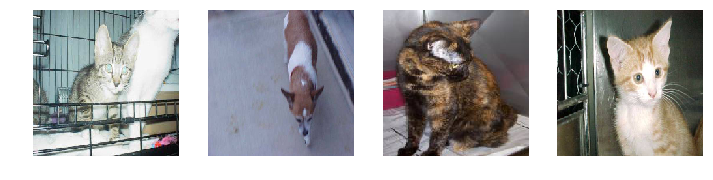

In [24]:
plots(test_batch[0][:4])

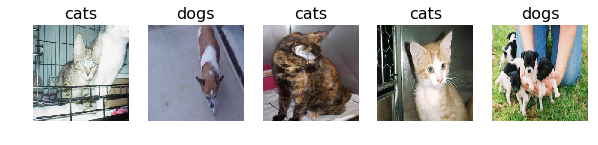

In [40]:
prediction = vgg.predict(test_batch[0])
plots(test_batch[0][:5], titles=prediction[2][:5])

In [16]:
# Compare test and train, make sure it's the same shape
test_img_x, _ = next(load_test_samples("data/kaggle/test"))
train_img_x, _ = next(train_batches)
print(test_img_x.shape)
print(train_img_x[0].shape)

(3, 224, 224)
(3, 224, 224)


In [33]:
test_img_x, _ = next(load_test_batches("data/kaggle/test"))
# print test_img_x.shape

prediction = vgg.predict(test_img_x)

In [39]:
print prediction[1]

[0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1
 1 0 0 1 0 0 1 0 1 0 1 1 0 0]


In [12]:
# Predict Kaggle test samples and write in Kaggle-expected format
with open("kaggle_submission_results.txt", "w") as f:
    f.write("id,label\n")
    for batch, ids in load_test_batches("data/kaggle/test"):
        scores, label_ids, labels = vgg.predict(batch)
        for sample_id, pred_label, sample_score in zip(ids, labels, scores):
            dog_score = sample_score if pred_label == "dogs" else 1.0 - sample_score
            
            # we want to avoid 1.0 and 0.0 
            score = max(min(dog_score, 0.98), 0.02)
            f.write("%s,%0.2f\n" % (sample_id, score))

## Submit to Kaggle

In [13]:
!kg submit -m "Using VGG16 fine-tuned from fastai, 3 epochs, lowering learning rate, using predicted scores" -c dogs-vs-cats-redux-kernels-edition "kaggle_submission_results.txt"

Starting new HTTPS connection (1): www.kaggle.com

